In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pingouin as pg
import pycircstat as pcs

from params import *
from events_coupling import event_coupling_job, concat_events_coupling_job
from rsp_detection import resp_tag_job
from circular_stats import HR2P
from configuration import base_folder

# SAVE FOLDER

In [5]:
# save_folder = base_folder / 'autres' /'article_N20' / 'clin_neurophy_submission2' / 'reviewing_2'
save_folder = base_folder / 'autres' /'article_N20' / 'clin_neurophy_submission2' / 'send_valentin_27022024'

# STATS & PLOT TOOLS

In [6]:
def get_circ_features(angles, univals=1000, seed=None, progress_bar = False, resample=True, size_resample = 10000): # angles in radians
    if angles.size > 10000 and resample:
        rng = np.random.default_rng(seed=seed)
        angles_resampled = rng.choice(angles, size = size_resample)
    else:
        angles_resampled = angles.copy()
    
    pval = HR2P(angles_resampled, univals=univals, seed=seed, progress_bar=progress_bar)

    mu = pg.circ_mean(angles) #+ np.pi
    mu = int(np.degrees(mu))
    r = round(pg.circ_r(angles), 3)

    if mu < 0:
        mu = 360 + mu

    return pval, mu, r

def get_mean_vector_features(angles): # angles in radians

    mu = pg.circ_mean(angles) #+ np.pi
    mu = int(np.degrees(mu))
    r = round(pg.circ_r(angles), 3)

    if mu < 0:
        mu = 360 + mu

    return mu, r

def pval_stars(p):
    if not np.isnan(p):
        if p >= 0.05:
            stars = 'ns'
        elif p < 0.05 and p >= 0.01:
            stars = '*'
        elif p < 0.01 and p >= 0.001:
            stars = '**'
        elif p < 0.001:
            stars = '***'
    else:
        stars = np.nan
    return stars

def load_angles(event, subject = '*', stage = '*', cooccuring = '*', speed = '*', chan = '*', quart_night = '*'):

    """
    High level function that load angles according to arguments and concatenate them if '*' argument

    Parameters (str)
    ----------
    event : 'Spindles' or 'SlowWaves'
    subject : From 'S1' to 'S20', '*' to concatenate all
    stage : 'N2' or 'N3, or '*' to concatenate all
    cooccuring : 'cooccur' or 'notcoocur', '*' to concatenate both
    speed : 'SS' or 'FS' for slow or fast spindles, '*' to concatenate both (useful only for spindles)
    quart_night : 'firsthalf' ot 'secondhalf' of night, '*' to concatenate both
    chan : 'Fz' for example or '*' to concatenate all
    """

    if subject == '*':
        df_angles = concat_events_coupling_job.get('global_key').to_dataframe()
    else:
        df_angles = event_coupling_job.get(subject).to_dataframe()

    df_angles = df_angles[df_angles['Event_type'] == event]

    if cooccuring == '*':
        mask_cooccuring = df_angles['cooccuring'].isin(df_angles['cooccuring'].unique())
    else:
        mask_cooccuring = df_angles['cooccuring'] == cooccuring
        
    if stage == '*':
        mask_stage = df_angles['Stage_Letter'].isin(df_angles['Stage_Letter'].unique())
    else:
        mask_stage = df_angles['Stage_Letter'] == stage        
    
    if speed == '*':
        mask_speed = df_angles['Sp_Speed'].isin(df_angles['Sp_Speed'].unique())
    else:
        mask_speed = df_angles['Sp_Speed'] == speed

    if chan == '*':
        mask_chan = df_angles['Channel'].isin(df_angles['Channel'].unique())
    else:
        mask_chan = df_angles['Channel'] == chan

    if quart_night == '*':
        mask_night = df_angles['night_quartile'].isin(df_angles['night_quartile'].unique())
    else:
        mask_night = df_angles['night_quartile'] == quart_night

    if event == 'Spindles':
        mask =  mask_stage & mask_cooccuring & mask_speed & mask_chan & mask_night 
    elif event == 'SlowWaves':
        mask = mask_stage & mask_cooccuring & mask_chan & mask_night 
        
    df_angles = df_angles[mask]
    return df_angles['Resp_Angle'].values

def circular_plot_angles(
    angles, 
    color = None, 
    ax=None, 
    ratio_plot = 0.42, 
    bins = 18, 
    with_rticks = True, 
    with_title = False, 
    with_arrow = True, 
    polar_ticks = 'full',
    lw = 10,
    progress_bar = False,
    univals= 1000,
    seed = None,
    with_stats = True,
    return_stats = False,
    resample = True):

    if ax is None:
        fig, ax = plt.subplots(subplot_kw=dict(projection = 'polar'), constrained_layout = True)
    if with_stats:
        pval, mu , r = get_circ_features(angles, univals=univals, seed=seed, progress_bar=progress_bar, resample = resample)
        stars = pval_stars(pval)
        stats = {'p':pval, 'mu':mu, 'r':r}

    N_events = angles.size # number of angles computed and distributed = number of events detected and computed (all subjects pooled)
    values, bins_hist, patches = ax.hist(angles, bins = bins, density = True, edgecolor = 'black', color = color ) # polar histogram of distribution of angles of all subjects (in radians)
    rmax = np.max(values)
    max_rticks = rmax + 0.05 * rmax

    if with_rticks:
        ax.set_rticks(np.arange(0,max_rticks,0.05))
        ax.set_rmax(max_rticks)
    else:
        ax.set_rticks([])

    step = np.pi / 180
    theta_inspi = np.arange(0, ratio_plot * 2*np.pi, step)
    theta_expi = np.arange(ratio_plot * 2*np.pi, 2*np.pi, step)
    for theta, color in zip([theta_inspi, theta_expi],['r','k']):
        r_plot = np.ones(theta.size) * rmax * 1.05
        ax.plot(theta, r_plot, lw = lw, color =color)
    
    if polar_ticks == 'full':
        ax.set_xticks(np.deg2rad([0, 90 , ratio_plot * 360 , 180 , 270])) # at this angles in degrees, ticks labels will be present
        ax.set_xticklabels(['Start', '90°', 'I>E', '180°','270°']) # labelize polar plot angles
    elif polar_ticks == 'light':
        ax.set_xticks([ratio_plot * 2*np.pi]) # at this angles in degrees, ticks labels will be present
        ax.set_xticklabels(['I>E']) # labelize polar plot angles
    
    if with_title:
        if with_stats:
            ax.set_title(f'N : {N_events} \n Mean Angle : {mu}° - MVL : {r} \n p-HermansRasson : {stars}')
        else:
            ax.set_title(f'N : {N_events}')
    if with_arrow:
        mu, r = get_mean_vector_features(angles)
        color_arrow = 'red'
        ax.arrow(np.deg2rad(mu), 0, 0, r, alpha = 1, width = 0.3, label = 'r', color=color_arrow, length_includes_head=True, head_width = 0.4, head_length =  0.01)
        
    return ax

def get_cycles_ratios(run_keys):
    concat = []
    for run_key in run_keys:
        to_concat = resp_tag_job.get(run_key).to_dataframe()
        to_concat['subject'] = run_key
        concat.append(to_concat)
    pooled_features = pd.concat(concat)

    cycle_ratio_by_sub_by_stage = pooled_features.groupby(['subject','sleep_stage'])['cycle_ratio'].mean(numeric_only = True).reset_index()
    mean_cycle_ratio_by_stage = pooled_features.groupby('sleep_stage')['cycle_ratio'].mean(numeric_only = True).reset_index()
    mean_cycle_ratio_by_stage.insert(0, 'subject','mean')
    cycles_ratios = pd.concat([cycle_ratio_by_sub_by_stage, mean_cycle_ratio_by_stage])
    return cycles_ratios

def get_respi_ratio(subject , stage, ratio_df):
    if subject == '*':
        subject_ratio = 'mean'
    else:
        subject_ratio  = subject

    if stage == '*':
        ratio = ratio_df.set_index(['subject','sleep_stage']).loc[(subject_ratio , ['N2','N3']), 'cycle_ratio'].mean()
    else:
        ratio = ratio_df.set_index(['subject','sleep_stage']).loc[(subject_ratio , stage), 'cycle_ratio']  
    return ratio

def readable_pval(pval):
    return round(pval, 4) if pval >= 0.001 else '< 0.001'

# RESP RATIOS

In [7]:
ratio_df = get_cycles_ratios(run_keys)
ratio_df

subject sleep_stage  cycle_ratio
0       S1          N1     0.423863
1       S1          N2     0.447983
2       S1          N3     0.429079
3       S1           R     0.486617
4       S1           W     0.433350
..     ...         ...          ...
0     mean          N1     0.409521
1     mean          N2     0.421494
2     mean          N3     0.423598
3     mean           R     0.451892
4     mean           W     0.393065

[105 rows x 3 columns]

# SPINDLES AND SLOWWAVES : FZ

## WITH STATS

101857
215776


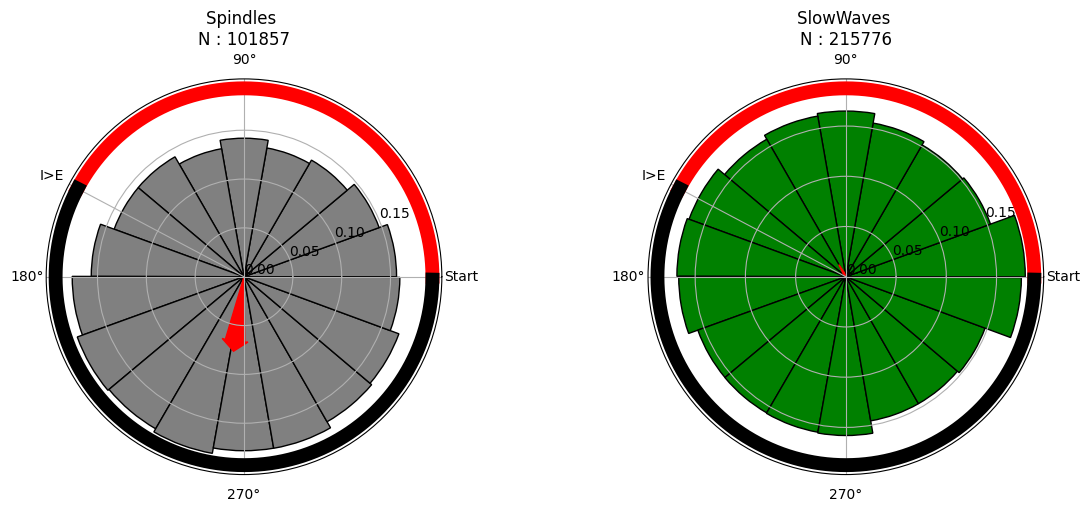

In [6]:
evs = ['Spindles','SlowWaves']
ncols = len(evs)
stage = '*'
# colors = {'Spindles':'grey','SlowWaves':'forestgreen'}

fig, axs = plt.subplots(ncols=ncols, figsize = (12,5), subplot_kw=dict(projection = 'polar'), constrained_layout = True)
for c, ev in enumerate(evs):
    color = 'g' if c == 1 else 'grey'
    ax = axs[c]
    ratio = get_respi_ratio(subject = '*', stage =stage, ratio_df = ratio_df)
    angles = load_angles(event = ev, chan = '*', stage = stage)
    print(angles.size)
    ax = circular_plot_angles(angles, with_title = True, ax = ax, color = color, ratio_plot = ratio, with_stats = False)
    ax.set_title(f'{ev} \n' + ax.get_title())
# fig.savefig(save_folder 'spindles_slowwaves_coupling.tif', dpi = 300, bbox_inches = 'tight')
plt.show()

10032
33710


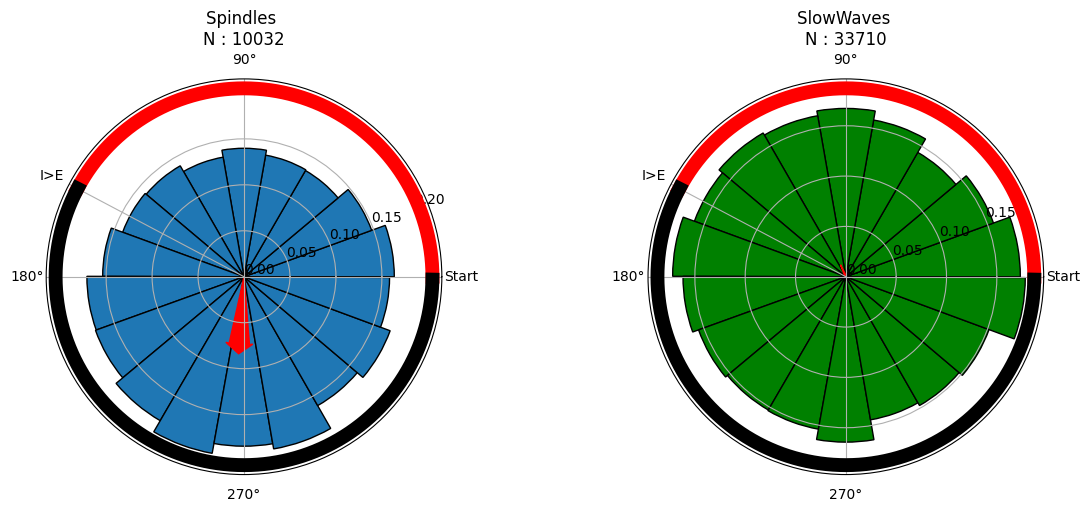

In [7]:
evs = ['Spindles','SlowWaves']
ncols = len(evs)
stage = '*'

fig, axs = plt.subplots(ncols=ncols, figsize = (12,5), subplot_kw=dict(projection = 'polar'), constrained_layout = True)
for c, ev in enumerate(evs):
    color = 'g' if c == 1 else None
    ax = axs[c]
    ratio = get_respi_ratio(subject = '*', stage =stage, ratio_df = ratio_df)
    angles = load_angles(event = ev, chan = 'Fz', stage = stage)
    print(angles.size)
    ax = circular_plot_angles(angles, with_title = True, ax = ax, color = color, ratio_plot = ratio, with_stats = False)
    ax.set_title(f'{ev} \n' + ax.get_title())
# fig.savefig(base_folder / 'autres' / 'article_N20' / 'clin_neurophy_submission2' / 'figs' / 'spindles_slowwaves_coupling.tif', dpi = 300, bbox_inches = 'tight')
plt.show()

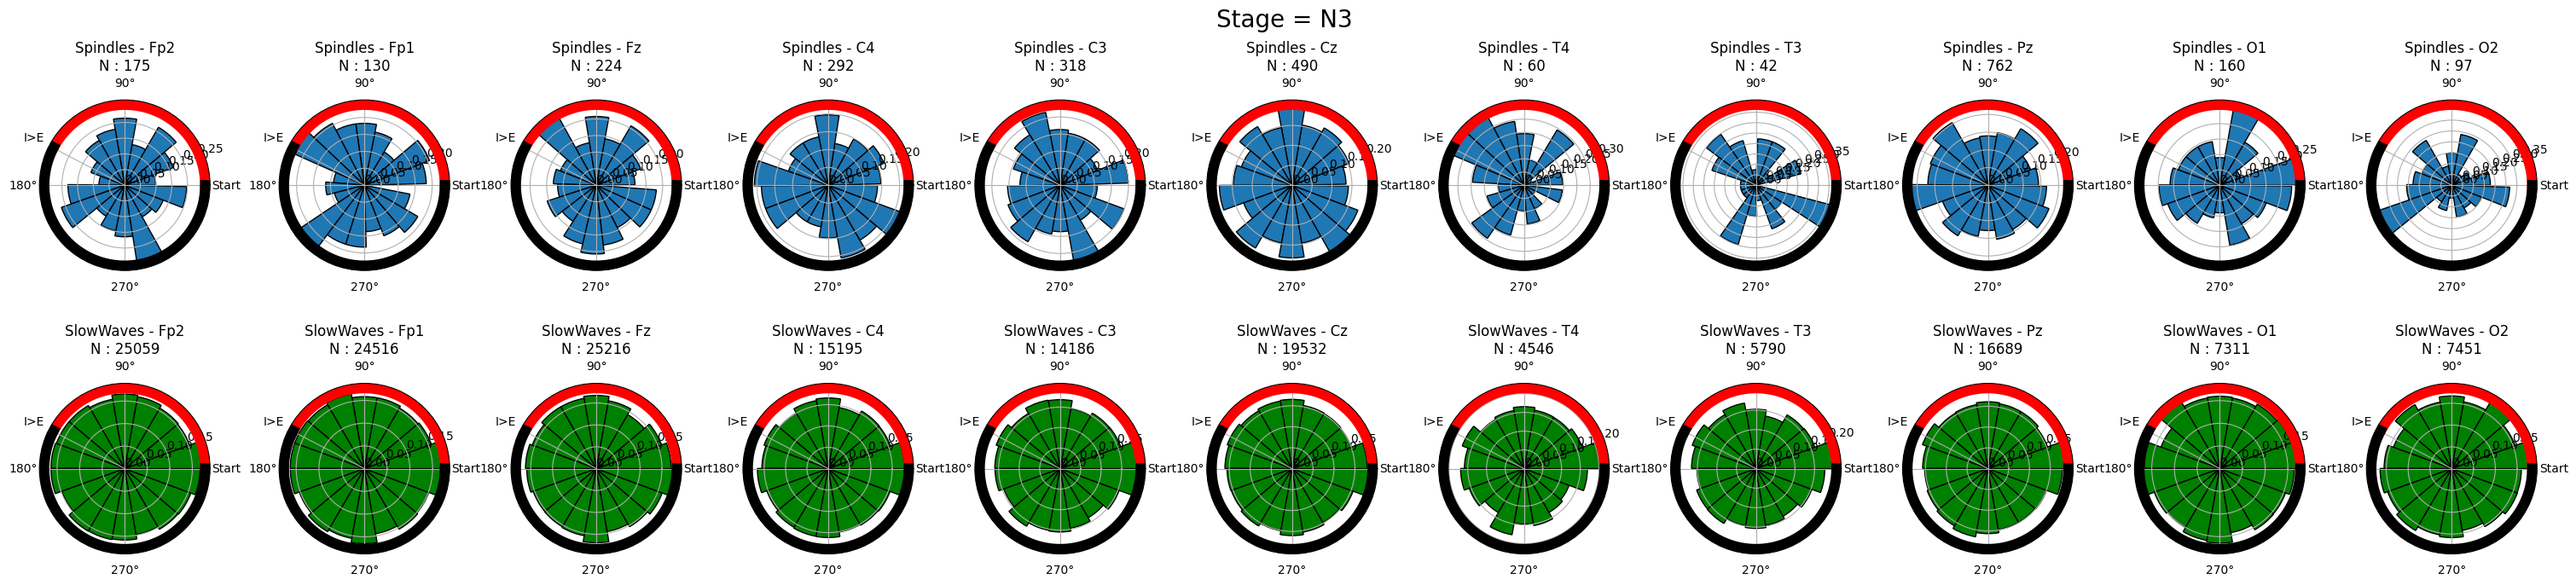

In [5]:
evs = ['Spindles','SlowWaves']
nrows = len(evs)
stage = 'N3'

fig, axs = plt.subplots(nrows=nrows, ncols = len(channels_events_select), figsize = (30,7), subplot_kw=dict(projection = 'polar'), constrained_layout = True)
fig.suptitle('Stage = N3', fontsize = 20)
for c, chan in enumerate(channels_events_select):
    for r, ev in enumerate(evs):
        color = 'g' if r == 1 else None
        ax = axs[r,c]
        ratio = get_respi_ratio(subject = '*', stage =stage, ratio_df = ratio_df)
        angles = load_angles(event = ev, chan = chan, stage = stage)
        # print(angles.size)
        ax = circular_plot_angles(angles, with_title = True, ax = ax, color = color, ratio_plot = ratio, with_stats = False)
        ax.set_title(f'{ev} - {chan}\n' + ax.get_title())
    fig.savefig(base_folder / 'autres' / 'article_N20' / 'clin_neurophy_submission2' / 'figs' / 'spindles_slowwaves_coupling_during_N3.tif', dpi = 300, bbox_inches = 'tight')
plt.show()

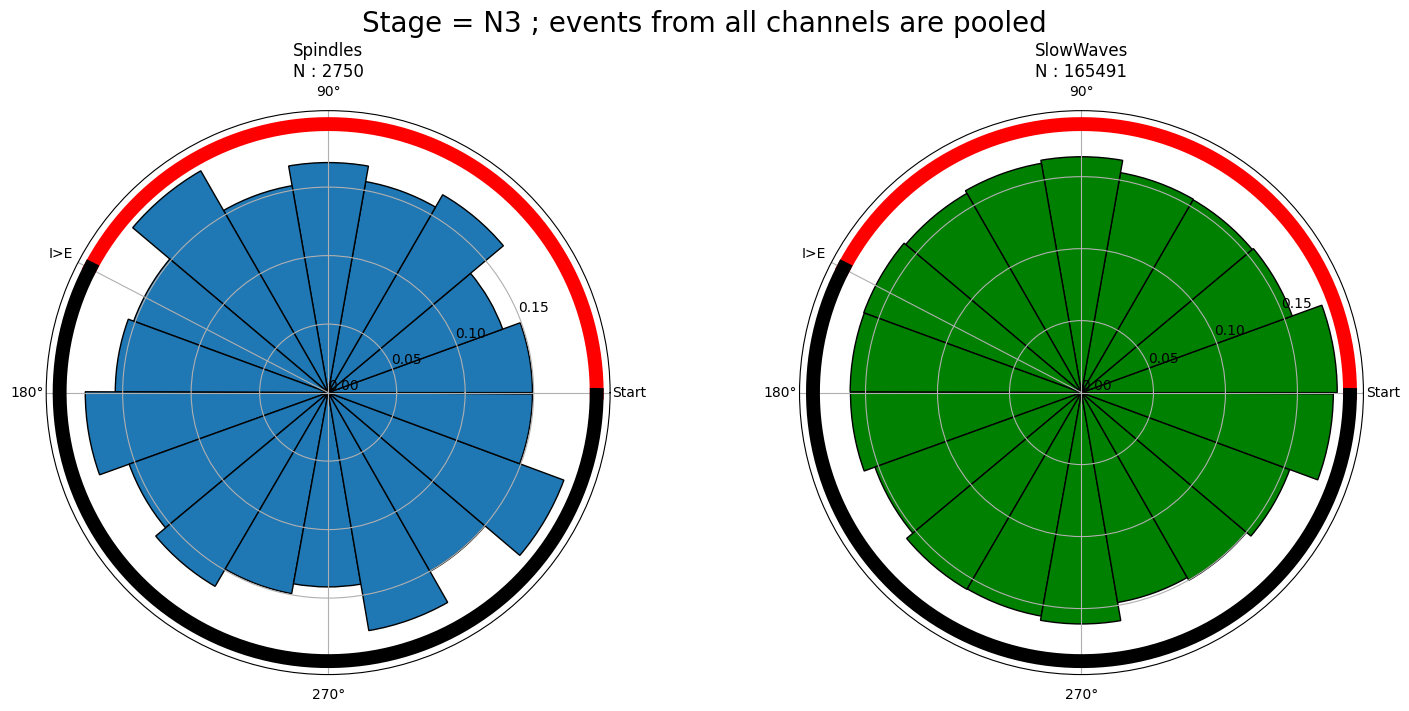

In [13]:
evs = ['Spindles','SlowWaves']
nrows = len(evs)
stage = 'N3'

fig, axs = plt.subplots(ncols = len(evs), figsize = (15,7), subplot_kw=dict(projection = 'polar'), constrained_layout = True)
fig.suptitle('Stage = N3 ; events from all channels are pooled', fontsize = 20)
for c, ev in enumerate(evs):
    color = 'g' if c == 1 else None
    ax = axs[c]
    ratio = get_respi_ratio(subject = '*', stage ='N3', ratio_df = ratio_df)
    angles = load_angles(event = ev, chan = '*', stage = stage)
    # print(angles.size)
    ax = circular_plot_angles(angles, with_title = True, ax = ax, color = color, ratio_plot = ratio, with_stats = False)
    ax.set_title(f'{ev}\n' + ax.get_title())
    fig.savefig(base_folder / 'autres' / 'article_N20' / 'clin_neurophy_submission2' / 'figs' / 'spindles_slowwaves_coupling_during_all_chans.png', dpi = 300, bbox_inches = 'tight')
plt.show()

## Figure 3A

10032
33710


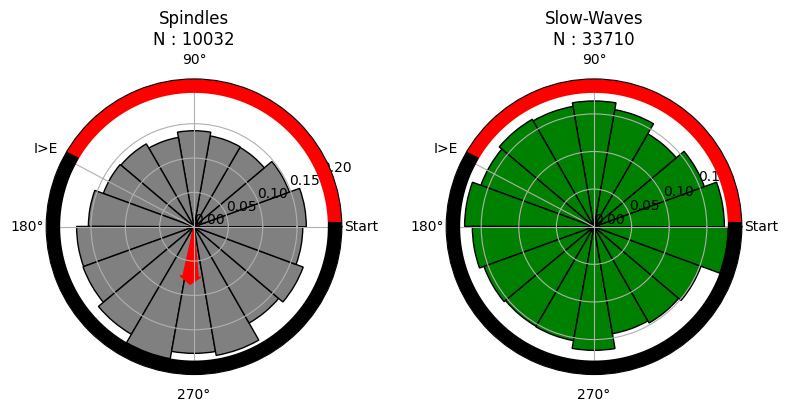

In [10]:
evs = ['Spindles','SlowWaves']
ncols = len(evs)
stage = '*'

fig, axs = plt.subplots(ncols=ncols, figsize = (8,4), subplot_kw=dict(projection = 'polar'), constrained_layout = True)
for c, ev in enumerate(evs):
    color = 'g' if c == 1 else 'grey'
    ax = axs[c]
    ratio = get_respi_ratio(subject = '*', stage =stage, ratio_df = ratio_df)
    angles = load_angles(event = ev, chan = 'Fz', stage = stage)
    print(angles.size)
    with_arrow = True if ev == 'Spindles' else False
    # with_stats = True if ev == 'Spindles' else False
    with_stats = False
    ax = circular_plot_angles(angles, with_title = False, ax = ax, color = color, ratio_plot = ratio, with_stats = with_stats, with_arrow = with_arrow)
    if not ev == 'SlowWaves':   
        ax.set_title(f'{ev}\nN : {angles.size}')
    else:
        ev = 'Slow-Waves'
        ax.set_title(f'{ev}\nN : {angles.size}')
fig.savefig(save_folder / 'Figure3A_N2N3_Fz.tif', dpi = 300, bbox_inches = 'tight')
# fig.savefig(save_folder / 'Figure3A.tif', dpi = 300, bbox_inches = 'tight')
plt.show()

101857
215776


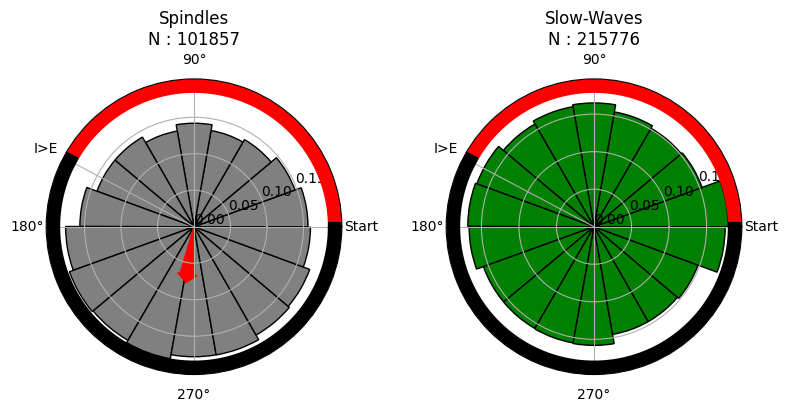

In [12]:
evs = ['Spindles','SlowWaves']
ncols = len(evs)
stage = '*'
chan = '*'

fig, axs = plt.subplots(ncols=ncols, figsize = (8,4), subplot_kw=dict(projection = 'polar'), constrained_layout = True)
for c, ev in enumerate(evs):
    color = 'g' if c == 1 else 'grey'
    ax = axs[c]
    ratio = get_respi_ratio(subject = '*', stage =stage, ratio_df = ratio_df)
    angles = load_angles(event = ev, chan = chan, stage = stage)
    print(angles.size)
    with_arrow = True if ev == 'Spindles' else False
    # with_stats = True if ev == 'Spindles' else False
    with_stats = False
    ax = circular_plot_angles(angles, with_title = False, ax = ax, color = color, ratio_plot = ratio, with_stats = with_stats, with_arrow = with_arrow)
    if not ev == 'SlowWaves':   
        ax.set_title(f'{ev}\nN : {angles.size}')
    else:
        ev = 'Slow-Waves'
        ax.set_title(f'{ev}\nN : {angles.size}')
fig.savefig(save_folder / 'Figure3A_N2N3_allchan.tif', dpi = 300, bbox_inches = 'tight')
# fig.savefig(save_folder / 'Figure3A.tif', dpi = 300, bbox_inches = 'tight')
plt.show()

# SPINDLES SLOW FAST : FZ

## WITH STATS

5172
4636


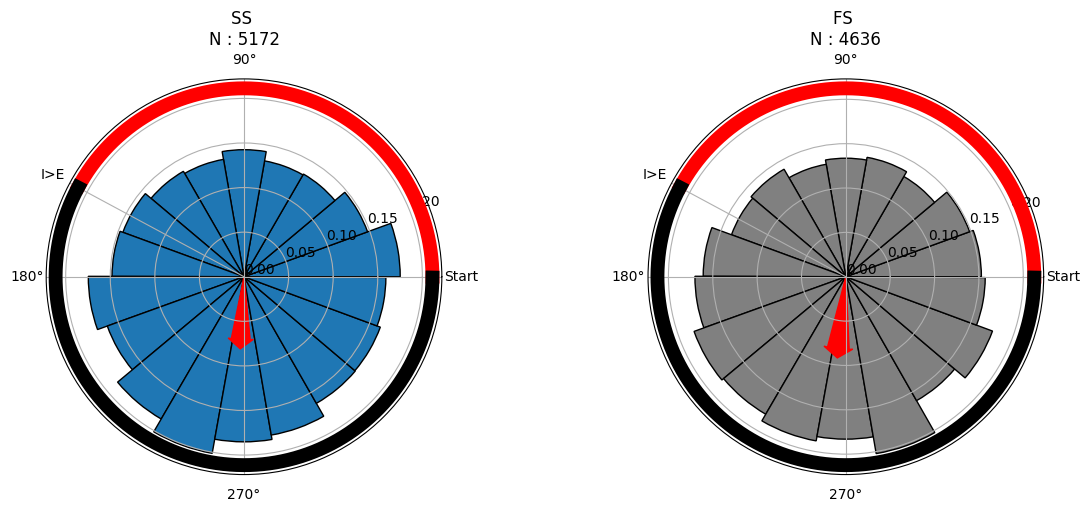

In [14]:
speeds = ['SS','FS']
ncols = len(speeds)
stage = 'N2'

fig, axs = plt.subplots(ncols=ncols, figsize = (12,5), subplot_kw=dict(projection = 'polar'), constrained_layout = True)
for c, speed in enumerate(speeds):
    color = 'grey' if c == 1 else None
    ax = axs[c]
    ratio = get_respi_ratio(subject = '*', stage =stage, ratio_df = ratio_df)
    angles = load_angles(event = 'Spindles', chan = 'Fz', stage = stage, speed = speed)
    print(angles.size)
    circular_plot_angles(angles, with_title = True, ax = ax, color = color, ratio_plot = ratio, with_stats = False)
    ax.set_title(f'{speed} \n' + ax.get_title())
# fig.savefig(save_folder / 'spindles_coupling_speeds.tif', dpi = 300, bbox_inches = 'tight')
plt.show()

## Figure 3B

5317
4715


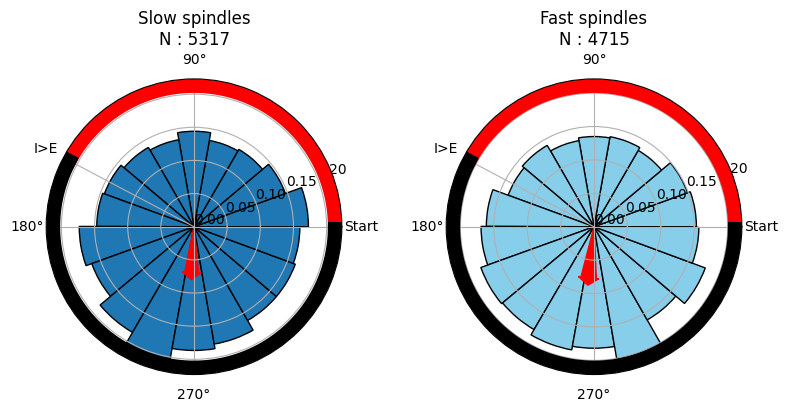

In [15]:
speeds = ['SS','FS']
speeds_titles = {'SS':'Slow spindles','FS':'Fast spindles'}
ncols = len(speeds)
stage = '*'

fig, axs = plt.subplots(ncols=ncols, figsize = (8,4), subplot_kw=dict(projection = 'polar'), constrained_layout = True)
for c, speed in enumerate(speeds):
    color = 'skyblue' if c == 1 else None
    ax = axs[c]
    ratio = get_respi_ratio(subject = '*', stage =stage, ratio_df = ratio_df)
    angles = load_angles(event = 'Spindles', chan = 'Fz', stage = stage, speed = speed)
    print(angles.size)
    circular_plot_angles(angles, with_title = False, ax = ax, color = color, ratio_plot = ratio, with_stats = False)
    speed_title = speeds_titles[speed]
    ax.set_title(f'{speed_title}\nN : {angles.size}')
fig.savefig(save_folder / 'Figure3B_N2N3_Fz.tif', dpi = 300, bbox_inches = 'tight')
# fig.savefig(save_folder / 'Figure3B.tif', dpi = 300, bbox_inches = 'tight')
plt.show()

36979
64878


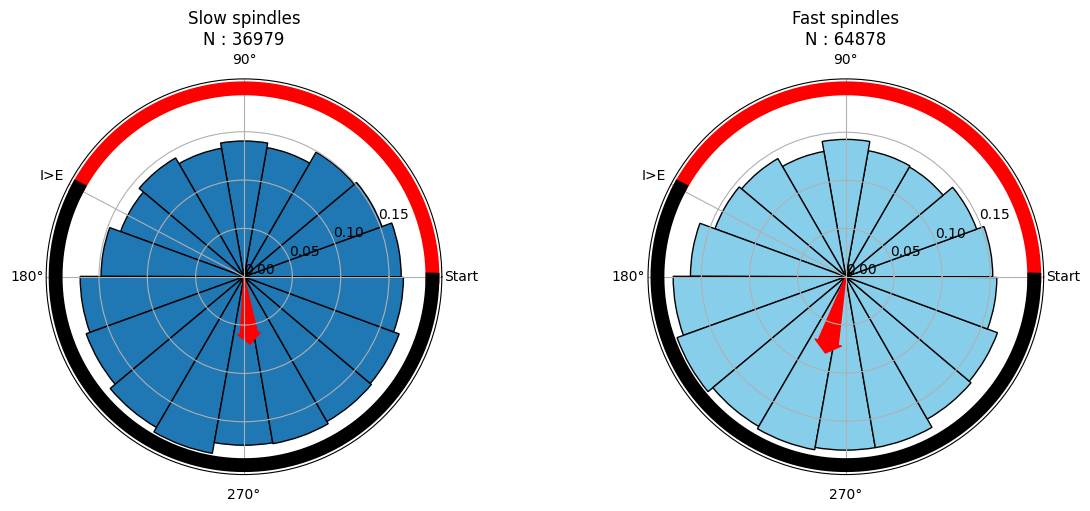

In [16]:
speeds = ['SS','FS']
speeds_titles = {'SS':'Slow spindles','FS':'Fast spindles'}
ncols = len(speeds)
stage = '*'

fig, axs = plt.subplots(ncols=ncols, figsize = (12,5), subplot_kw=dict(projection = 'polar'), constrained_layout = True)
for c, speed in enumerate(speeds):
    color = 'skyblue' if c == 1 else None
    ax = axs[c]
    ratio = get_respi_ratio(subject = '*', stage =stage, ratio_df = ratio_df)
    angles = load_angles(event = 'Spindles', chan = '*', stage = stage, speed = speed)
    print(angles.size)
    circular_plot_angles(angles, with_title = False, ax = ax, color = color, ratio_plot = ratio, with_stats = False)
    speed_title = speeds_titles[speed]
    ax.set_title(f'{speed_title}\nN : {angles.size}')
fig.savefig(save_folder / 'Figure3B_N2N3_allchan.tif', dpi = 300, bbox_inches = 'tight')
# fig.savefig(save_folder / 'Figure3B.tif', dpi = 300, bbox_inches = 'tight')
plt.show()

## Figure 3C

In [28]:
chans = chans_events_detect
stage = '*'
angles_dict = {'Slow spindles':{chan:load_angles(event = 'Spindles', chan = chan, stage = stage, speed = 'SS') for chan in chans},
          'Fast spindles':{chan:load_angles(event = 'Spindles', chan = chan, stage = stage, speed = 'FS') for chan in chans},
          'Slow-Waves':{chan:load_angles(event = 'SlowWaves', chan = chan, stage = stage) for chan in chans}
         }

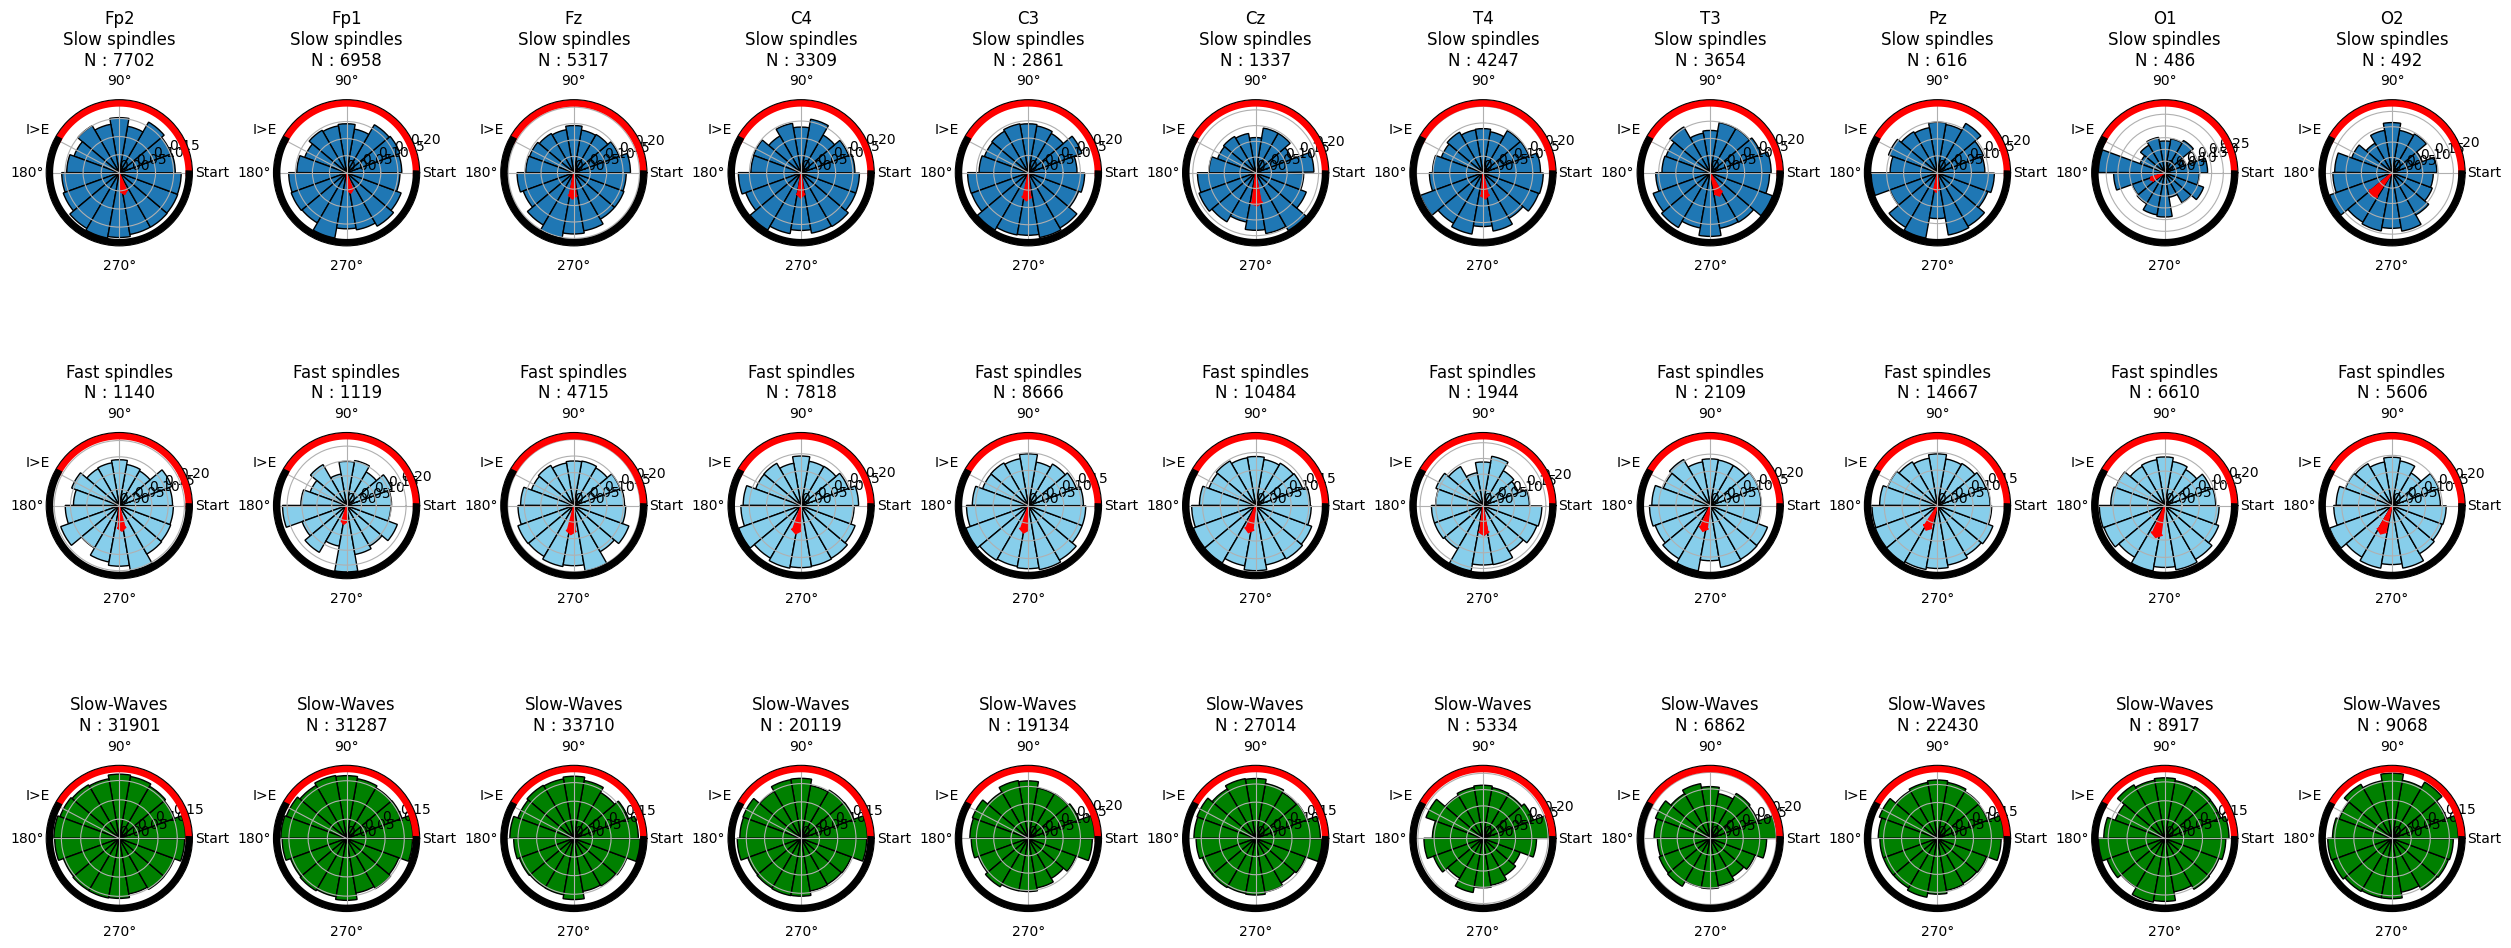

In [30]:
colors = {'Slow spindles':None, 'Fast spindles':'skyblue', 'Slow-Waves':'g'}

ncols = len(chans_events_detect)
nrows =  len(angles_dict.keys())

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (25,10), subplot_kw=dict(projection = 'polar'), constrained_layout = True)

for r, ev in enumerate(angles_dict.keys()):
    color = colors[ev]
    for c, chan in enumerate(chans):
        ax = axs[r,c]
        ratio = get_respi_ratio(subject = '*', stage ='*', ratio_df = ratio_df)
        angles = angles_dict[ev][chan]
        with_arrow = True if 'spindles' in ev else False
        # with_stats = True if 'spindles' in ev else False
        with_stats = False
        circular_plot_angles(angles, with_title = False, ax = ax, color = color, ratio_plot = ratio, with_stats = with_stats, with_arrow = with_arrow, lw = 5)
        if r == 0:
            ax.set_title(f'{chan}\n{ev}\nN : {angles.size}')
        else:
            ax.set_title(f'{ev}\nN : {angles.size}')
fig.savefig(save_folder / 'Figure3C_N2N3.tif', dpi = 300, bbox_inches = 'tight')
# fig.savefig(save_folder / 'Figure3C.tif', dpi = 300, bbox_inches = 'tight')
plt.show()

# NIGHT QUARTILE SPINDLE & SLOW WAVES PHASING : FZ - N2

## ALL SPINDLES

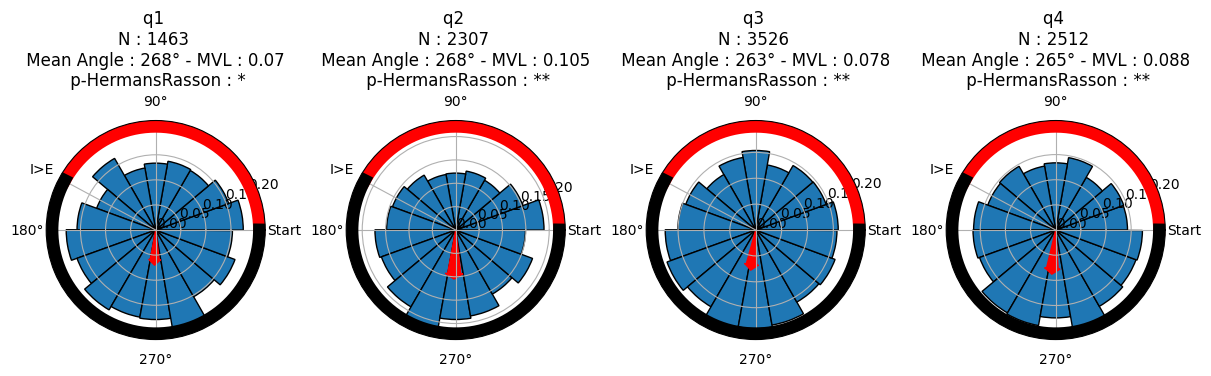

In [13]:
qs = ['q1','q2','q3','q4']
ncols = len(qs)
stage = 'N2'

fig, axs = plt.subplots(ncols=ncols, figsize = (12,5), subplot_kw=dict(projection = 'polar'), constrained_layout = True)
for c, q in enumerate(qs):
    ax = axs[c]
    ratio = get_respi_ratio(subject = '*', stage = stage, ratio_df = ratio_df)
    angles = load_angles(event = 'Spindles', chan = 'Fz', quart_night = q, speed = '*', stage = stage)
    circular_plot_angles(angles, with_title = True, ax = ax, ratio_plot=ratio)
    ax.set_title(f'{q} \n' + ax.get_title())
# fig.savefig(save_folder / 'spindles_coupling_quartnight.tif', dpi = 300, bbox_inches = 'tight')
plt.show()

## SLOW VS FAST SPINDLES

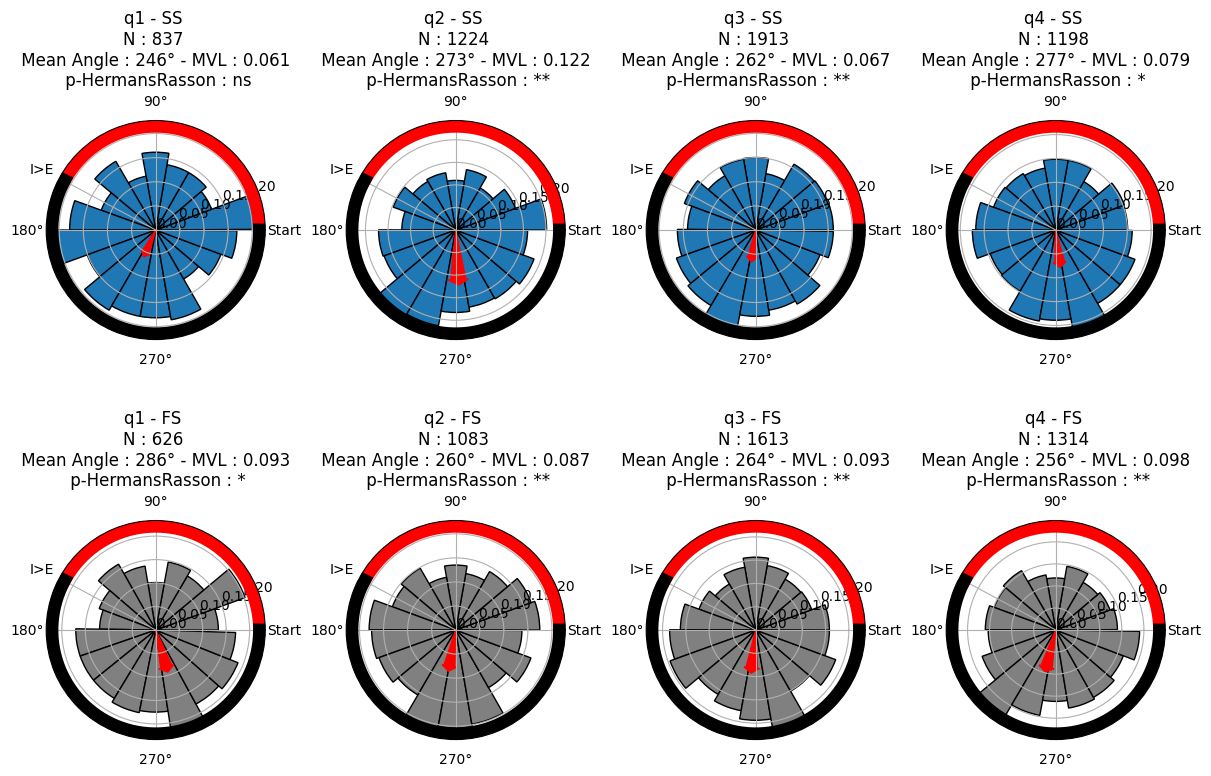

In [14]:
qs = ['q1','q2','q3','q4']
speeds = ['SS','FS']
stage = 'N2'

ncols = len(qs)
nrows = len(speeds)

fig, axs = plt.subplots(nrows = nrows, ncols=ncols, figsize = (12,8), subplot_kw=dict(projection = 'polar'), constrained_layout = True)
for c, q in enumerate(qs):
    for r, speed in enumerate(speeds):
        color = 'grey' if r == 1 else None
        ax = axs[r,c]
        ratio = get_respi_ratio(subject = '*', stage = stage, ratio_df = ratio_df)
        angles = load_angles(event = 'Spindles', chan = 'Fz', quart_night = q, speed = speed, stage = stage)
        circular_plot_angles(angles, with_title = True, ax = ax, color = color, ratio_plot = ratio)
        ax.set_title(f'{q} - {speed} \n' + ax.get_title())
        
# fig.savefig(save_folder / 'spindles_coupling_quartnight_speed.tif', dpi = 300, bbox_inches = 'tight')
plt.show()

## SLOW-WAVES

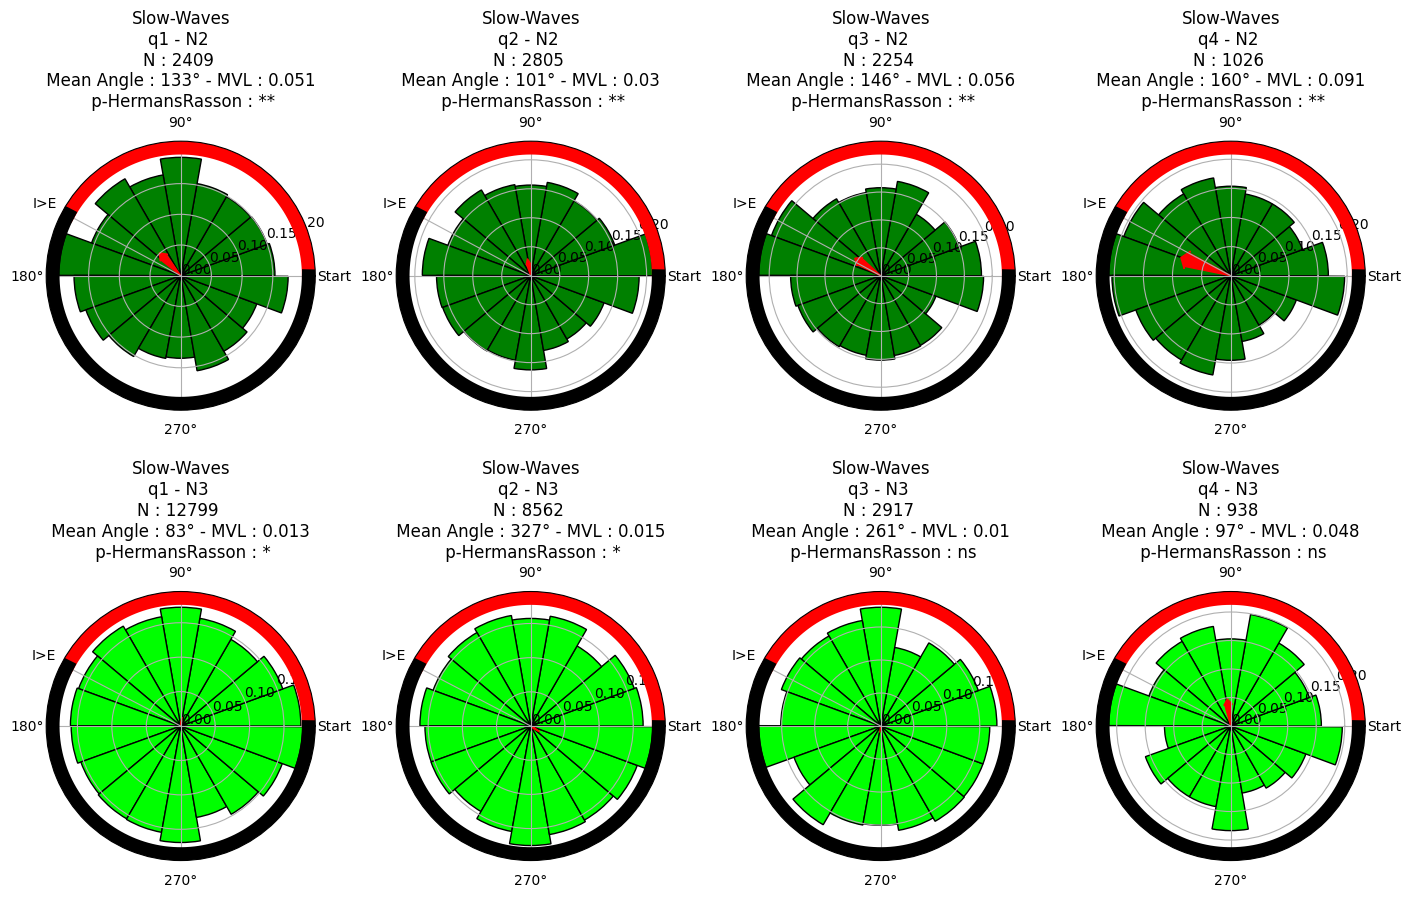

In [15]:
qs = ['q1','q2','q3','q4']
stages = ['N2','N3']
colors = {'N2':'g', 'N3':'lime'}
nrows = len(stages)
ncols = len(qs)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (14,9), subplot_kw=dict(projection = 'polar'), constrained_layout = True)
for r, stage in enumerate(stages):
    for c, q in enumerate(qs):
        ax = axs[r,c]
        ratio = get_respi_ratio(subject = '*', stage = stage, ratio_df = ratio_df)
        angles = load_angles(event = 'SlowWaves', chan = 'Fz', quart_night = q, speed = '*', stage = stage)
        circular_plot_angles(angles, with_title = True, ax = ax, ratio_plot=ratio, color = colors[stage])
        ax.set_title(f'Slow-Waves\n{q} - {stage} \n' + ax.get_title())
# fig.savefig(save_folder / 'slowwaves_coupling_quartnight.tif', dpi = 300, bbox_inches = 'tight')
plt.show()

## Figure 4

In [9]:
qs = ['q1','q2','q3','q4']
stage = '*'
angles_dict = {'Slow spindles':{q:load_angles(event = 'Spindles', chan = '*', stage = stage, speed = 'SS', quart_night = q) for q in qs},
          'Fast spindles':{q:load_angles(event = 'Spindles', chan = '*', stage = stage, speed = 'FS', quart_night = q) for q in qs},
          'Slow-Waves':{q:load_angles(event = 'SlowWaves', chan = '*', stage = stage, quart_night = q) for q in qs}
         }
colors = {'Slow spindles':{0:'dimgrey',1:'darkgrey',2:'silver',3:'gainsboro'},
          'Fast spindles':{0:'darkblue',1:'tab:blue',2:'cornflowerblue',3:'skyblue'},
          'Slow-Waves':{0:'darkgreen',1:'g',2:'forestgreen',3:'lime'}
         }

colors = {'Slow spindles':{0:'skyblue',1:'skyblue',2:'skyblue',3:'skyblue'},
          'Fast spindles':{0:'tab:blue',1:'tab:blue',2:'tab:blue',3:'tab:blue'},
          'Slow-Waves':{0:'g',1:'g',2:'g',3:'g'}
         }

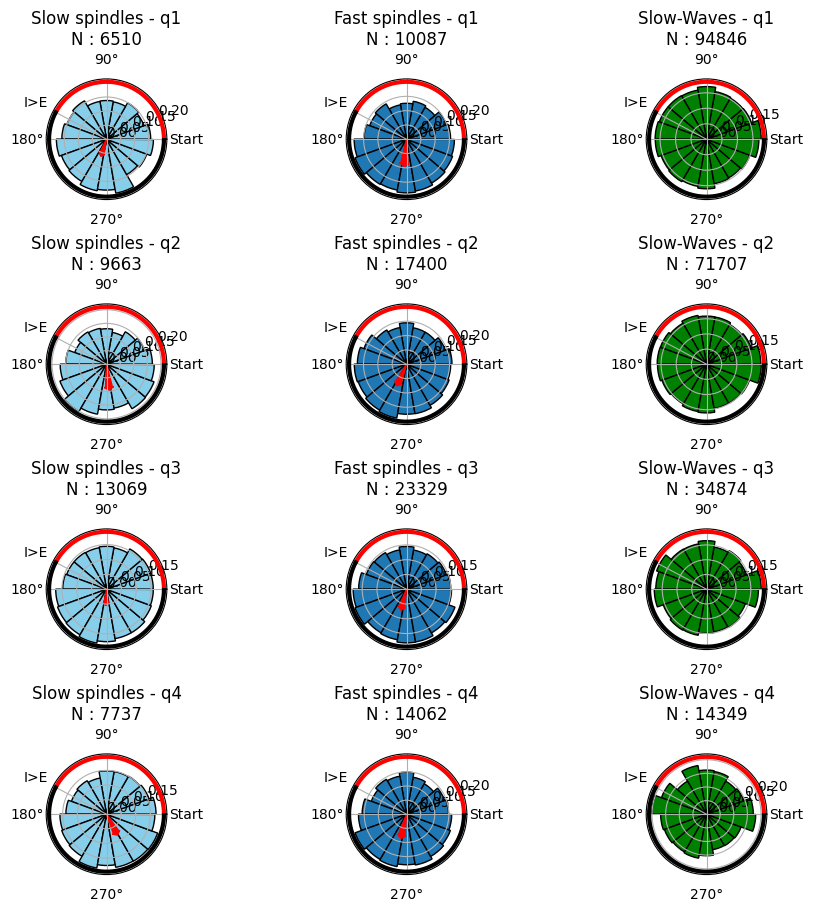

In [12]:
ncols = len(angles_dict.keys())
nrows =  4

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (9,9), subplot_kw=dict(projection = 'polar'), constrained_layout = True)

for c, ev in enumerate(angles_dict.keys()):
    for r, q in enumerate(qs):
        ax = axs[r,c]
        ratio = get_respi_ratio(subject = '*', stage = stage, ratio_df = ratio_df)
        angles = angles_dict[ev][q]
        with_arrow = True if 'spindles' in ev else False
        # with_stats = True if 'spindles' in ev else False
        with_stats = False
        circular_plot_angles(angles, with_title = False, ax = ax, color = colors[ev][r], ratio_plot = ratio, with_stats = with_stats, with_arrow = with_arrow, lw = 3)
        ax.set_title(f'{ev} - {q}\nN : {angles.size}')
# fig.savefig(save_folder / 'Figure4_N2N3_allchan.tif', dpi = 300, bbox_inches = 'tight')
fig.savefig(save_folder / 'Figure4.tif', dpi = 300, bbox_inches = 'tight')
plt.show()

# CO-OCCURING vs NOT COOCCURING ALL ELECTRODES

# Figure 3D

591
101266


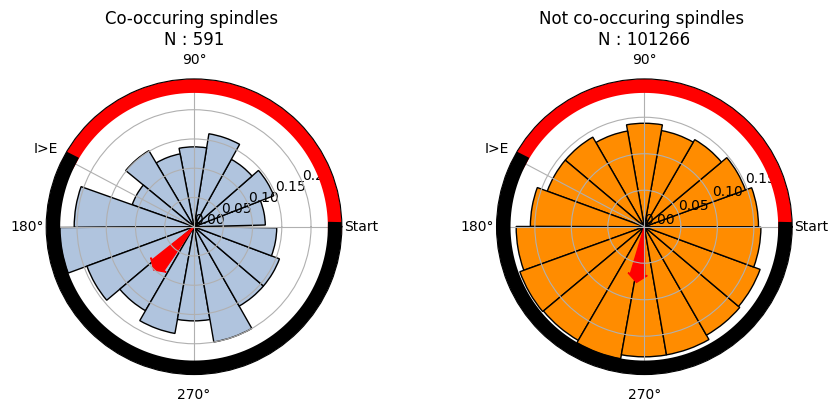

In [27]:
coocs = ['cooccur','notcooccur']
cooc_titles = {'cooccur':'Co-occuring spindles' , 'notcooccur':'Not co-occuring spindles'}

ncols = len(coocs)

stage = '*'

fig, axs = plt.subplots(ncols=ncols, figsize = (9,4), subplot_kw=dict(projection = 'polar'), constrained_layout = True)
# fig.suptitle('N2 + N3 pooled')
for c, cooc in enumerate(coocs):
    color = 'darkorange' if c == 1 else 'lightsteelblue'
    ax = axs[c]
    ratio = get_respi_ratio(subject = '*', stage = stage, ratio_df = ratio_df)
    angles = load_angles(event = 'Spindles', stage = stage, cooccuring = cooc)
    print(angles.size)
    circular_plot_angles(angles, with_title = True, ax = ax, color = color, ratio_plot = ratio, progress_bar = True, with_stats = False)
    cooc_title = cooc_titles[cooc]
    ax.set_title(f'{cooc_title} \n' + ax.get_title())
        
fig.savefig(save_folder / f'Figure3D_N2N3_allchan_spindles.tif', dpi = 300, bbox_inches = 'tight')
# fig.savefig(save_folder / f'Figure3D.tif', dpi = 300, bbox_inches = 'tight')
plt.show()

# CO OCCURING / NOT CO OCCURING SLOW WAVES

605
215171


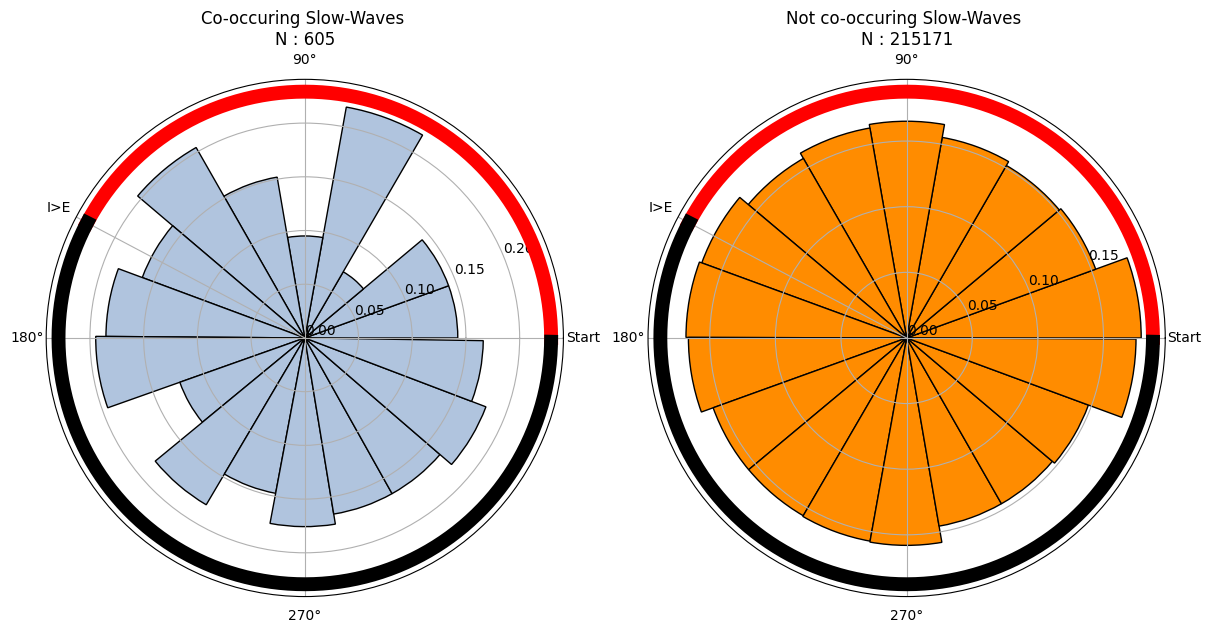

In [9]:
coocs = ['cooccur','notcooccur']
cooc_titles = {'cooccur':'Co-occuring Slow-Waves' , 'notcooccur':'Not co-occuring Slow-Waves'}

ncols = len(coocs)

stage = '*'

fig, axs = plt.subplots(ncols=ncols, figsize = (12,8), subplot_kw=dict(projection = 'polar'), constrained_layout = True)
# fig.suptitle('N2 + N3 pooled')
for c, cooc in enumerate(coocs):
    color = 'darkorange' if c == 1 else 'lightsteelblue'
    ax = axs[c]
    ratio = get_respi_ratio(subject = '*', stage = stage, ratio_df = ratio_df)
    angles = load_angles(event = 'SlowWaves', stage = stage, cooccuring = cooc)
    print(angles.size)
    circular_plot_angles(angles, with_title = True, ax = ax, color = color, ratio_plot = ratio, progress_bar = True, with_stats = False, with_arrow = False)
    cooc_title = cooc_titles[cooc]
    ax.set_title(f'{cooc_title} \n' + ax.get_title())
        
fig.savefig(save_folder / f'Figure3D_N2N3_allchan_SlowWaves.tif', dpi = 300, bbox_inches = 'tight')
plt.show()

# WATSON-WILLIAMS FAST vs SLOW

In [7]:
sp_f = load_angles('Spindles', speed = 'FS')
sp_s = load_angles('Spindles', speed = 'SS')

<PolarAxesSubplot: title={'center': 'N : 36979'}>

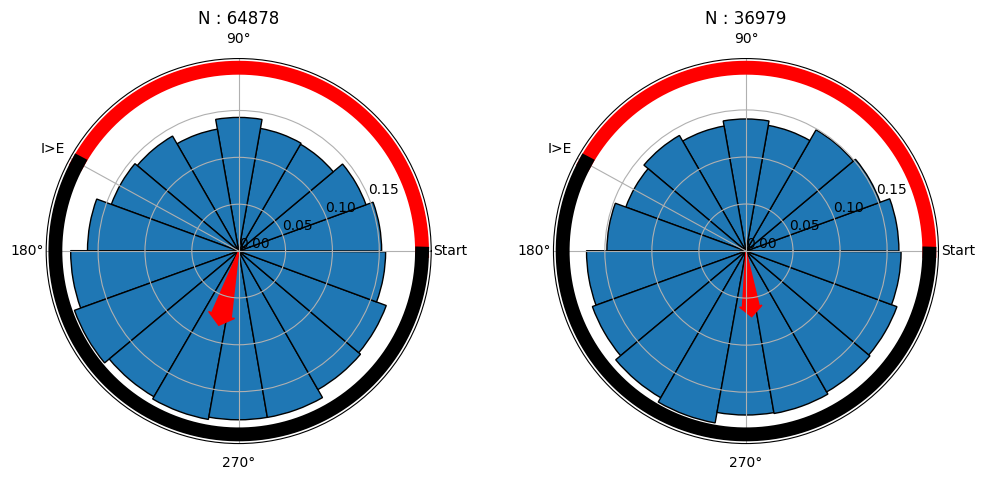

In [12]:
fig, axs = plt.subplots(ncols = 2, subplot_kw = {'projection':'polar'}, figsize = (12,5))
ax = axs[0]
circular_plot_angles(sp_f, with_stats = False, ax=ax, with_title = True)
ax = axs[1]
circular_plot_angles(sp_s, with_stats = False, ax=ax, with_title = True)

In [17]:
p, _ = pcs.watson_williams(sp_f, sp_s)

/home/valentin.ghibaudo/.virtualenvs/py3.10_nodegpu/lib/python3.10/site-packages/pycircstat/tests.py:416: UserWarning: Test not applicable. Average resultant vector length < 0.45.
  warnings.warn(


In [18]:
df

df            SS          MS          F       p-value
Source                                                               
Columns        1.0    110.421139  110.421139  407.98859  1.512831e-90
Residual  101855.0  93950.087842    0.922391        NaN           NaN
Total     101856.0  94060.508981         NaN        NaN           NaN

In [27]:
rows = []
for stage in ['*','N2','N3']:
    for q in ['*','q1','q2','q3','q4']:
        sp_f = load_angles('Spindles', speed = 'FS', stage = stage, quart_night = q)
        sp_s = load_angles('Spindles', speed = 'SS', stage = stage, quart_night = q)
        p,_= pcs.watson_williams(sp_f, sp_s)
        rows.append([stage, q, p, readable_pval(p), pval_stars(p)])
ww = pd.DataFrame(rows, columns = ['Stage','Quart-Night','p-value','p-value clean','Significance'])

/home/valentin.ghibaudo/.virtualenvs/py3.10_nodegpu/lib/python3.10/site-packages/pycircstat/tests.py:416: UserWarning: Test not applicable. Average resultant vector length < 0.45.
  warnings.warn(
/home/valentin.ghibaudo/.virtualenvs/py3.10_nodegpu/lib/python3.10/site-packages/pycircstat/tests.py:416: UserWarning: Test not applicable. Average resultant vector length < 0.45.
  warnings.warn(
/home/valentin.ghibaudo/.virtualenvs/py3.10_nodegpu/lib/python3.10/site-packages/pycircstat/tests.py:416: UserWarning: Test not applicable. Average resultant vector length < 0.45.
  warnings.warn(
/home/valentin.ghibaudo/.virtualenvs/py3.10_nodegpu/lib/python3.10/site-packages/pycircstat/tests.py:416: UserWarning: Test not applicable. Average resultant vector length < 0.45.
  warnings.warn(
/home/valentin.ghibaudo/.virtualenvs/py3.10_nodegpu/lib/python3.10/site-packages/pycircstat/tests.py:416: UserWarning: Test not applicable. Average resultant vector length < 0.45.
  warnings.warn(
/home/valentin.

In [30]:
# ww.to_excel(base_folder / 'autres' / 'article_N20' / 'clin_neurophy_submission2' / 'watson_williams_speed_spindles.xlsx', index = False)

# EXAMPLES DOWN SAMPLING FOR REVIEWER 3

In [16]:
q = 'q3'
ex1_angles = load_angles(event = 'Spindles', speed = 'SS', quart_night = q)
ex2_angles = load_angles(event = 'Spindles', speed = 'FS', quart_night = q)
ex3_angles = load_angles(event = 'SlowWaves', quart_night = q)

In [25]:
import time

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:40<00:00,  6.21it/s]


161.1290598170017


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:34<00:00, 10.62it/s]


94.23286089400062


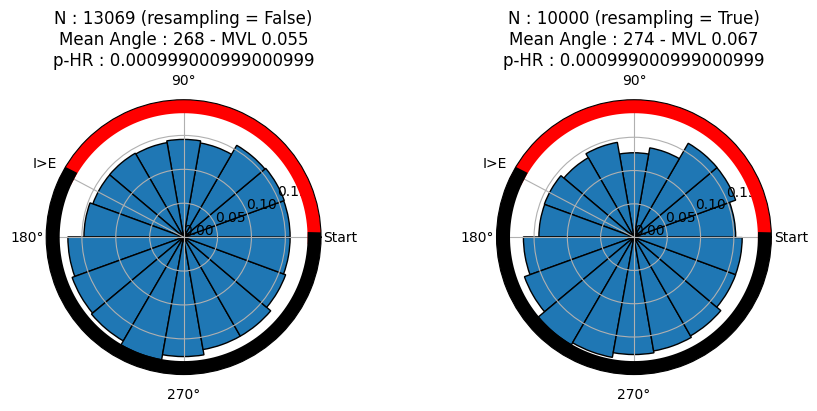

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:25<00:00,  1.98it/s]


505.823451147


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:34<00:00, 10.62it/s]


94.2598917639989


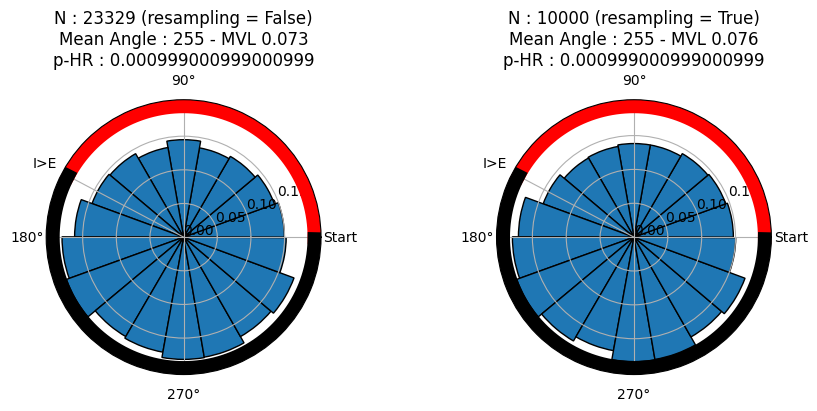

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [19:04<00:00,  1.14s/it]


1145.750862613997


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:35<00:00, 10.49it/s]


95.49623237399646


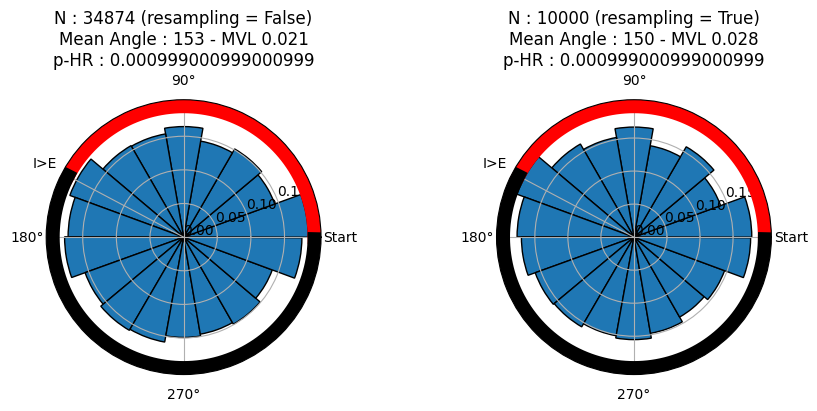

In [28]:
size_resample = 10000

for i, ex_angles in enumerate([ex1_angles, ex2_angles, ex3_angles]):
    fig, axs = plt.subplots(ncols = 2, figsize = (9,4), constrained_layout = True, subplot_kw=dict(projection = 'polar'))
    ratio = get_respi_ratio(subject = '*', stage = '*', ratio_df = ratio_df)
    
    for c, resampling in enumerate([False, True]):
        ax = axs[c]
        
        if resampling:
            seed = None
            rng = np.random.default_rng(seed=seed)
            angles_resampled = rng.choice(ex_angles, size = size_resample)
        else:
            angles_resampled = ex_angles.copy()
        t1 = time.perf_counter()
        p, mu, r = get_circ_features(angles_resampled, univals = 1000, seed = None, progress_bar = True, resample = False)
        t2 = time.perf_counter()
        computation_time = t2 - t1
        print(computation_time)
        circular_plot_angles(angles_resampled, with_title = False, ax = ax, ratio_plot = ratio, progress_bar = False, with_stats = False, with_arrow = False, resample = False)
        ax.set_title(f'N : {angles_resampled.size} (resampling = {str(resampling)})\nMean Angle : {mu} - MVL {r}\np-HR : {p}')
    
    fig.savefig(save_folder / f'down_sampling_example{i+1}.png', dpi = 500, bbox_inches = 'tight')
    plt.show()

23329


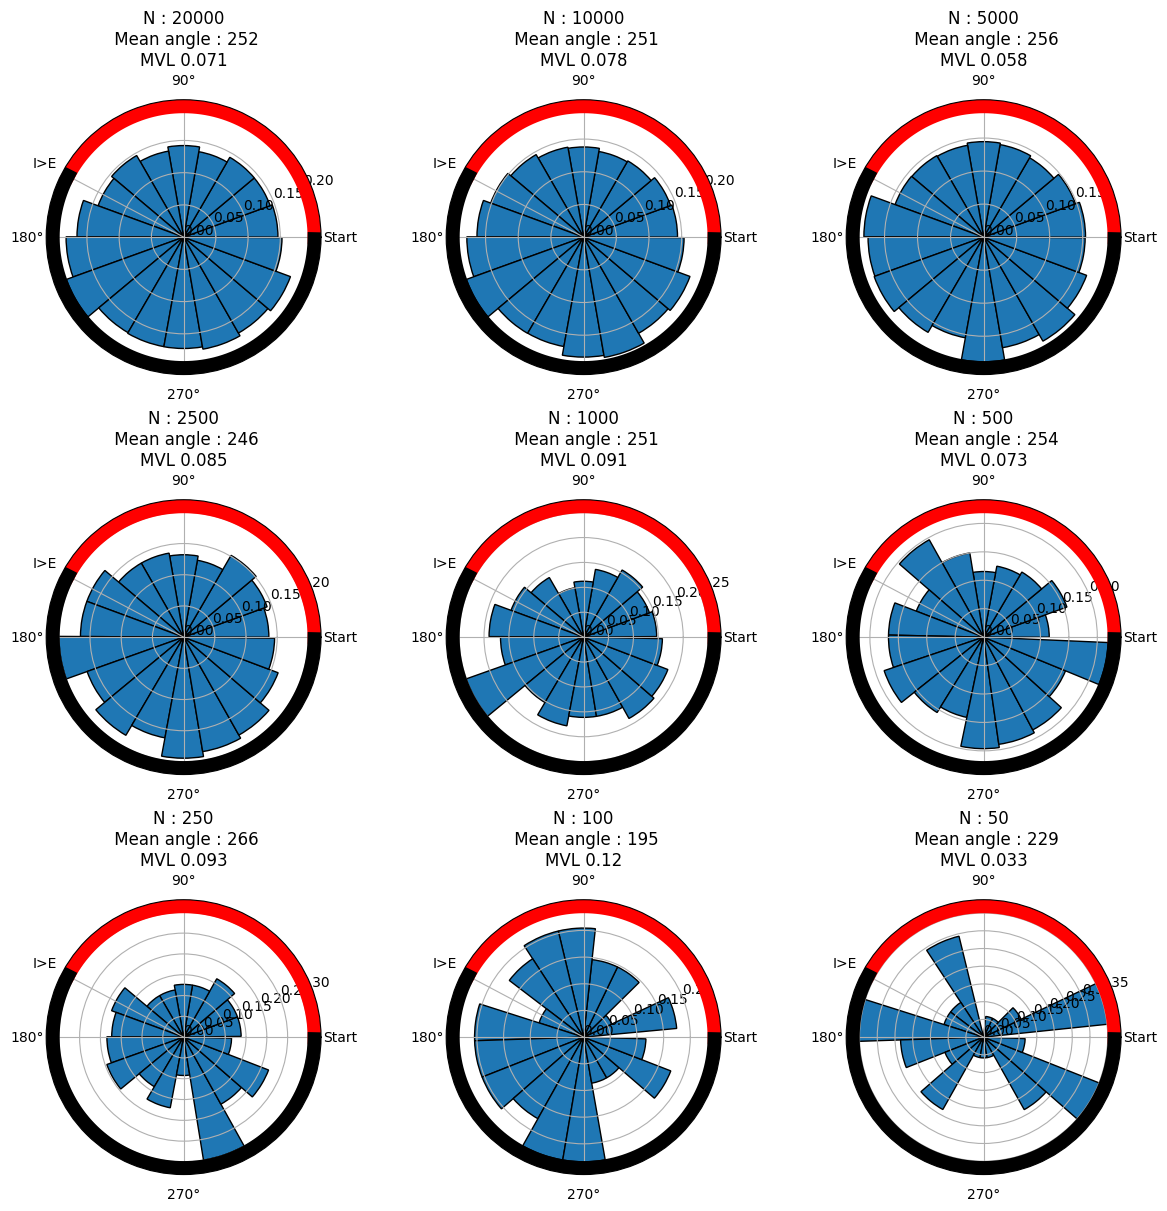

In [47]:
angles = ex2_angles.copy()
print(angles.size)

resample_sizes = [20000, 10000, 5000,2500, 1000, 500, 250, 100, 50]

nrows = 3
ncols = 3

resample_sizes_array = np.array(resample_sizes).reshape(nrows, ncols)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, constrained_layout = True, figsize = (12,12), subplot_kw=dict(projection = 'polar'))
for row in range(nrows):
    for col in range(ncols):
        ax = axs[row,col]
        seed = None
        rng = np.random.default_rng(seed=seed)
        angles_resampled = rng.choice(angles, size = resample_sizes_array[row,col])
        mu = pg.circ_mean(angles_resampled) #+ np.pi
        mu = int(np.degrees(mu))
        r = round(pg.circ_r(angles_resampled), 3)

        if mu < 0:
            mu = 360 + mu
        circular_plot_angles(angles_resampled, with_title = False, ax = ax, ratio_plot = ratio, progress_bar = False, with_stats = False, with_arrow = False)
        ax.set_title(f'N : {angles_resampled.size}\n Mean angle : {mu}\nMVL {r}')
# fig.savefig(save_folder / 'effect_down_sampling.png', dpi = 500, bbox_inches = 'tight')
plt.show()
